# Importing usefull libraries and downloading the data

In [45]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from IPython.display import display
import sys
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, mean_squared_error
sys.path.append('../..')
import warnings

warnings.filterwarnings('ignore')

from scripts import dataframe as dfr

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

In [4]:
!wget $data

--2022-10-27 10:32:51--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  2.07MB/s    in 0.7s    

2022-10-27 10:32:53 (2.07 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [3]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
usefull_cols = [

    'latitude',

    'longitude',

    'housing_median_age',

    'total_rooms',

    'total_bedrooms',

    'population',

    'households',

    'median_income',

    'median_house_value',

    'ocean_proximity'
]

In [5]:
df = data[usefull_cols]
df = dfr.data_frame_refining(df)
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,near_bay
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,near_bay
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,near_bay
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,near_bay
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,near_bay


In [6]:
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
df = df.fillna(0)
df.isna().sum()

latitude              0
longitude             0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [8]:
y = df['median_house_value'].to_numpy()
y_trans = np.log1p(y)

In [9]:
df['median_house_value'] = y_trans

In [10]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value
y_val = df_val.median_house_value
y_test = df_test.median_house_value

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

x_train = dv.fit_transform(train_dicts)
x_val = dv.transform(val_dicts)
x_test = dv.transform(test_dicts)

# Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity=INLAND`
* `total_rooms`
* `latitude`
* `population`

In [11]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(export_text(dt,feature_names = dv.get_feature_names()))

|--- ocean_proximity=inland <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=inland >  0.50
|   |--- value: [11.61]



> The answer will be `ocean_proximity=INLAND`

# Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.05
* 0.25
* 0.55
* 0.85

In [13]:
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
    )
rf.fit(x_train,y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [16]:
y_pred = rf.predict(x_val)
rmse = mean_squared_error(y_val,y_pred,squared=False)
rmse.round(2)

0.25

# Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 150

In [18]:
scores = []

for n in range(10,201,10):

    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=1,
        n_jobs=-1
        )
    rf.fit(x_train,y_train)
    y_pred = rf.predict(x_val)
    rmse = mean_squared_error(y_val,y_pred,squared=False)

    scores.append((n,rmse))

In [21]:
df_scores = pd.DataFrame(scores,columns=['n_estimators','rmse'])
df_scores.round(3)

,n_estimators,rmse
0,10,0.246
1,20,0.239
2,30,0.235
3,40,0.234
4,50,0.233
5,60,0.233
6,70,0.232
7,80,0.232
8,90,0.232
9,100,0.232


Text(0, 0.5, 'rmse')

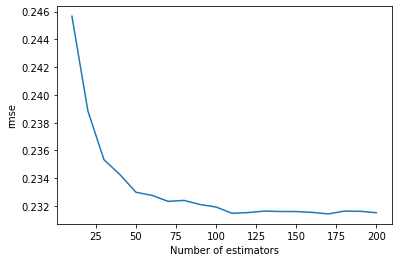

In [22]:
plt.plot(df_scores.n_estimators,df_scores.rmse)
plt.xlabel('Number of estimators')
plt.ylabel('rmse')

> At n_estimator 150 the rmse stops improving

# Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [23]:
scores = []

for depth in [10,15,20,25]:
    for n in range(10,201,10):

        rf = RandomForestRegressor(
            max_depth=depth,
            n_estimators=n,
            random_state=1,
            n_jobs=-1
            )
        rf.fit(x_train,y_train)
        y_pred = rf.predict(x_val)
        rmse = mean_squared_error(y_val,y_pred,squared=False)

        scores.append((n,depth,rmse))

In [28]:
df_scores = pd.DataFrame(scores,columns=['n_estimators','max_depth','rmse'])
df_scores_pivot = df_scores.pivot(index='n_estimators',columns=['max_depth'],values=['rmse'])
df_scores_pivot

rmse                              
max_depth           10        15        20        25
n_estimators                                        
10            0.254599  0.245030  0.245931  0.246374
20            0.252577  0.239357  0.238488  0.238915
30            0.251463  0.236785  0.235734  0.235612
40            0.250919  0.235971  0.234705  0.234719
50            0.250069  0.234758  0.233384  0.233066
60            0.250002  0.234738  0.233283  0.232665
70            0.249847  0.234213  0.232744  0.232253
80            0.249561  0.234101  0.232677  0.232097
90            0.249289  0.233899  0.232453  0.231793
100           0.249140  0.233748  0.232211  0.231596
110           0.248910  0.233360  0.231969  0.231362
120           0.248979  0.233332  0.231901  0.231334
130           0.249112  0.233438  0.231964  0.231565
140           0.249219  0.233362  0.231835  0.231498
150           0.249203  0.233299  0.231807  0.231504
160           0.249130  0.233241  0.231771  0.231485
170           0.248924  0.233233  0.231712  0.231436
180           0.249032  0.233389  0.231894  0.231552
190           0.249105  0.233460  0.231876  0.231530
200           0.249126  0.233383  0.231766  0.231417

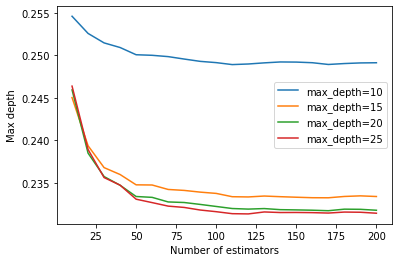

In [26]:
for d in [10,15,20,25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators,df_subset.rmse,label=f'max_depth={d}')
    plt.xlabel('Number of estimators')
    plt.ylabel('Max depth')

plt.legend()

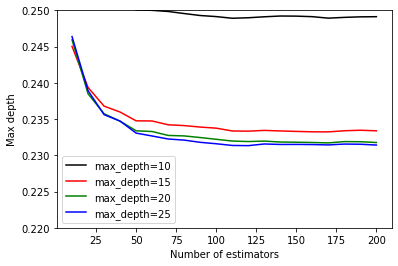

In [33]:
d = [10,15,20,25]
colors = ['black','red','green','blue']

for d,col in zip(d,colors) :
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators,df_subset.rmse,label=f'max_depth={d}',color=col)
    plt.xlabel('Number of estimators')
    plt.ylabel('Max depth')

plt.ylim(0.22,0.25)
plt.legend()

> Maximum depth of 25 is the best

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`

In [34]:
rf = RandomForestRegressor(
            max_depth=20,
            n_estimators=10,
            random_state=1,
            n_jobs=-1
            )

rf.fit(x_train,y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

<BarContainer object of 13 artists>

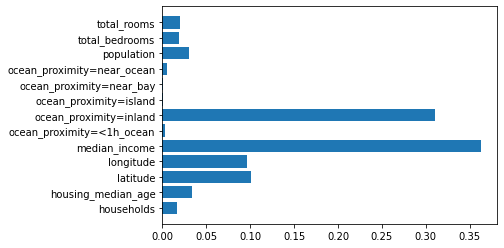

In [43]:
plt.barh(dv.get_feature_names(),rf.feature_importances_)

> Median income is the most important feature

# Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same

In [46]:
features = dv.get_feature_names()
regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]
dtrain = xgb.DMatrix(
    x_train,
    label=y_train,
    feature_names=features
    )
dval =xgb.DMatrix(x_val,feature_names=features)

In [50]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round = 200
)

y_pred = model.predict(dval)
rmse_eta_point_3 = mean_squared_error(y_val,y_pred,squared=False)
rmse_eta_point_3

0.22479291696836884

In [51]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round = 200
)

y_pred = model.predict(dval)
rmse_eta_point_1 = mean_squared_error(y_val,y_pred,squared=False)
rmse_eta_point_1

0.2242767450311036

In [53]:
print(f'eta 0.3 rmse is {rmse_eta_point_3.round(4)}')
print(f'eta 0.1 rmse is {rmse_eta_point_1.round(4)}')

eta 0.3 rmse is 0.2248
eta 0.1 rmse is 0.2243


> Both give almost the same accuracy